In [0]:
#Использовался google colab
from google.colab import files
!pip install -U -q PyDrive
!pip install imbalanced-learn
!pip install kaggle

In [11]:
files.upload()

Saving class_magnesium_not_drop_na.py to class_magnesium_not_drop_na.py


{'class_magnesium_not_drop_na.py': b'import numpy as np\nimport pandas as pd\n\nimport matplotlib\nimport matplotlib.pyplot as plt\nimport matplotlib.patches as mpatches\nget_ipython().magic(\'matplotlib inline\')\n\nimport os\nfrom copy import deepcopy\n\nfrom sklearn.model_selection import GroupKFold, GroupShuffleSplit\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit\nfrom sklearn.feature_selection import SelectFromModel\n\nfrom sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score\nfrom sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, f1_score\n\ntry:\n    from tqdm import tnrange, tqdm_notebook\n    tqdm = True\nexcept ImportError:\n    tqdm = False\n    pass\n\nfrom matplotlib import colors as mcolors\nfrom matplotlib import cm\nimport random\n\nimport re\n\nimport itertools\nfrom sklearn.utils.multiclass import check_classificatio

In [0]:
!mv kaggle.json /content/.kaggle/

In [10]:
!kaggle competitions download -c ml-mipt-spring2018-1

train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!mv /content/.kaggle/competitions/ml-mipt-spring2018-1/* /content/

In [0]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
import sklearn

import sys
sys.path.insert(0, 'basic_codes')

import class_magnesium_not_drop_na #_transform_pairings
from class_magnesium_not_drop_na import *
import pandas as pd

def load_data(filename):
    '''
        Функция для загрузки датасета без инициализации класса. 
        
        Возвращает:
         data - полный DataFrame
         fetures - список признаков для обучения/предсказания
         x - датасет для тренировки/предсказания в формате np.array
         y - целевой признак, если он есть. В случае с тестовым датасетом возвращает None
    '''
    
    data = pd.read_table(filename, sep=',').dropna()    
    
    data = data[~(data['chainlen']>1000)]

    if ('DSSR' in data.columns):
        data.drop('DSSR', axis=1, inplace=True)    
    
    features = list(deepcopy(data.columns))
    [features.remove(column) for column in ['Id','index', 'pdb_chain', 'mg'] if column in data.columns];
    x_test = np.array(data[features])
    
    try:
        y_test = np.array(data['mg'])
    except: 
        y_test = None
    change_output('Data loaded')
    return {'data':data, 'features':features, 'x':x_test, 'y':y_test}

In [17]:
fold = ''
file_train = 'train.csv'
file_test = 'test.csv'
estimators=1500
m = Magnesium(file_train, fold = fold, model = AdaBoostClassifier(n_estimators=estimators))  

Everything is OK. Ready for your experiments!

In [18]:
%%time
rm_model = RandomForestClassifier(n_estimators=20).fit(m.x, m.y)
sfm = SelectFromModel(rm_model, prefit=True)
x = sfm.transform(m.x)
rus = RandomUnderSampler(random_state=42)
x_res, y_res = rus.fit_sample(x, m.y)

CPU times: user 34.9 s, sys: 0 ns, total: 34.9 s
Wall time: 34.9 s


In [20]:
%%time
m.trained_model = deepcopy(m.model)
m.trained_model.fit(x_res, y_res)

CPU times: user 6min 5s, sys: 53 ms, total: 6min 5s
Wall time: 6min 5s


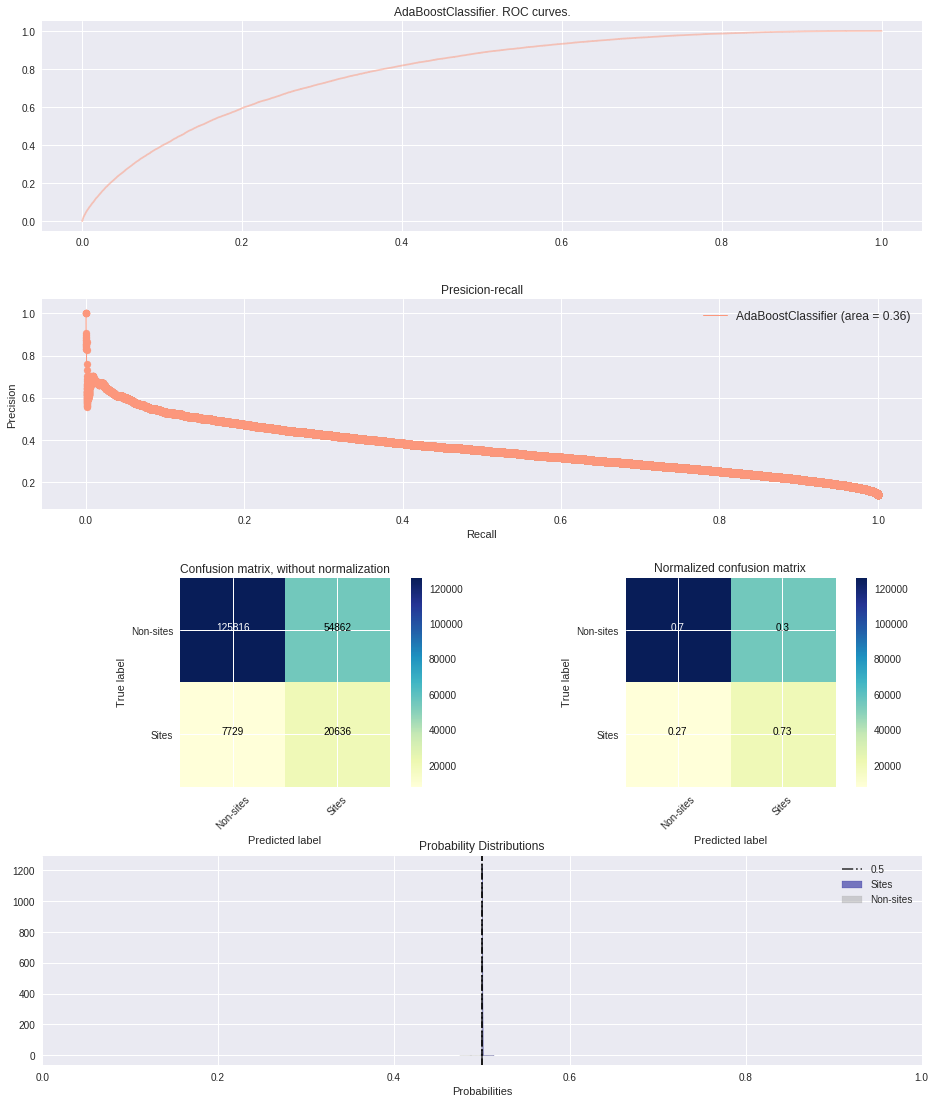

In [21]:
predict_train =  m.predict(x = x, 
                           y = m.y,
                           model=m.trained_model, 
                           plots = True)

In [22]:
test = load_data(fold+file_test)
test_x = sfm.transform(test['x'])
pred = m.trained_model.predict(test_x)
df = pd.DataFrame(pred, columns =['mg'])
df.index.name='Id'
df.to_csv('result.csv')
files.download('result.csv')

Data loaded